In [3]:
import os

using_colab = False
if using_colab:
  os.system('rm -rf ./*')
  os.system('git clone https://github.com/gasparyanartur/radio-optimizer.git')
  os.system('mv radio-optimizer/* ./')
  os.system('rm -rf radio-optimizer')

(no blockage)	PWM: PEB = 0.026133+0.000000j | CEB = 0.013426+0.000000j
(with blockage)	PWM: PEB = 0.069256+0.000000j | CEB = 0.064823+0.000000j


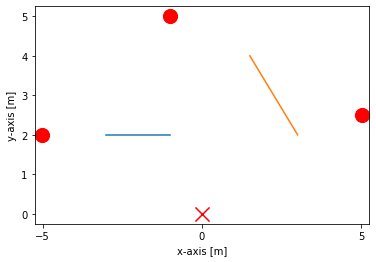

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time

from src.utils import db2pow, setup_fig

from src.channel_mmWave_parameters import ChannelmmWaveParameters

c = ChannelmmWaveParameters(
    PB = np.array([0, -0.01, 0]).reshape(-1, 1),
    OB = np.array([45, 0, 0]).reshape(-1, 1),
    NB_dim = np.array([1, 1]).reshape(-1, 1),
    PR = np.array([[-5.01, 2, 0.5], [-1, 5.01, 0.5], [5.01, 2.5, 0.5]]).T,
    OR = np.array([[0, 0, 0], [-90, 0, 0], [180, 0, 0]]).T,
    NR_dim = np.array([[10, 10], [10, 10], [10, 10]]).T,
    PU = np.array([-2, 3, -1.5]).reshape(-1, 1),
    OU = np.array([0, 0, 0]).reshape(-1, 1),
    NU_dim = np.array([1, 1]).reshape(-1, 1),
    P = db2pow(15),
    K = 64,
    G = 10,

    seed=1
)

c.get_beam_matrix()
c.get_tx_symbol()
c.get_path_parameters_PWM()
c.get_FIM_PWM()

fim = c.FIM
c.get_crlb_from_fim_PWM(fim)
print(f"(no blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")

setup_fig()
c.plot_scene()

point = np.array([2, 4])
blockage = c.get_blockage(point)
c.get_crlb_blockage(blockage)

print(f"(with blockage)\tPWM: PEB = {c.PEB:.6f} | CEB = {c.CEB:.6f}")

c0 = c.copy()

In [5]:
grid_size = 0.5     # ~7s
#grid_size = 0.2     # ~42s
#grid_size = 0.1     # ~160s


xgrid = np.arange(-5, 5+grid_size, grid_size)
ygrid = np.arange(0, 5+grid_size, grid_size)

PEB_mat = np.zeros((xgrid.size, ygrid.size))
PEB_cell = np.zeros((xgrid.size, ygrid.size), dtype='complex_')

print_runtimes = False
verbosity = 1

tot_time = time.time()
y_runtimes = []
x_runtimes = []

for xi in range(xgrid.size):
    if verbosity >= 1:
        print(f"xi: {xi}/{xgrid.size}")

    x_time = time.time()

    for yi in range(ygrid.size):
        if verbosity >= 2:
            print(f"yi: {yi}/{ygrid.size}")

        y_time = time.time()
        c = c0.copy()

        c.PU = np.array([xgrid[xi], ygrid[yi], 1]).reshape(-1, 1)
        c.update_parameters()
        c.get_path_parameters_PWM()
        c.get_FIM_PWM()
        c.get_crlb_from_fim_PWM(c.FIM)

        blockage = c.get_blockage(c.PU[:2].T)
        c.get_crlb_blockage(blockage)
        PEB_cell[xi, yi] = c.PEB

        y_runtimes.append(time.time() - y_time)
    
    x_runtimes.append(time.time() - x_time)

if print_runtimes:
    print(f"Total Runtime: {time.time() - tot_time: .3f}s")
    print("Mean y runtime:", np.mean(y_runtimes))
    print("Mean x runtime:", np.mean(x_runtimes))
    
...;

xi: 0/21
xi: 1/21
xi: 2/21
xi: 3/21
xi: 4/21
xi: 5/21
xi: 6/21
xi: 7/21
xi: 8/21
xi: 9/21
xi: 10/21
xi: 11/21
xi: 12/21
xi: 13/21
xi: 14/21
xi: 15/21
xi: 16/21
xi: 17/21
xi: 18/21
xi: 19/21
xi: 20/21


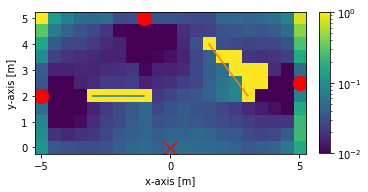

In [7]:
import matplotlib as mpl

PEB_mat = PEB_cell.copy()
PEB_mat[np.isnan(PEB_cell) | (np.abs(PEB_cell) > 100)] = 100

X, Y = np.meshgrid(xgrid, ygrid)

margin = 0.25
cbar_shrink=0.65

setup_fig()
plt.title('PEB of ... []')
img = plt.imshow(PEB_mat.T.real, origin='lower', norm=mpl.colors.LogNorm(vmin=0.01, vmax=1), extent=[-5-margin, 5+margin, -margin, 5+margin])
plt.colorbar(img, pad=0.04, shrink=cbar_shrink, aspect=20*cbar_shrink)
c.plot_scene()

...;